Dependencies installation and all required imports.

In [1]:
!pip install transformers --q
!pip install bitsandbytes --q
!pip install peft --q
!pip install accelerate --q
!pip install datasets --q
!pip install evaluate --q

In [2]:
import os
os.environ["HF_ALLOW_CODE_EVAL"] = "1"

import torch
from transformers.utils import logging
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

logging.set_verbosity(logging.ERROR)

import matplotlib.pyplot as plt

from datasets import load_dataset
from evaluate import load
import bitsandbytes

import locale # colab workaround
locale.getpreferredencoding = lambda: "UTF-8" # colab workaround

Loading PEFT model (using quantization).

In [3]:
model_path = "smallcloudai/Refact-1_6B-fim"

tokenizer = AutoTokenizer.from_pretrained(model_path)
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token

use_4bit = True
bnb_4bit_compute_dtype = "float16"
bnb_4bit_quant_type = "nf4"
use_nested_quant = False

compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)

model = AutoModelForCausalLM.from_pretrained(model_path,
                                             return_dict=True,
                                             quantization_config=bnb_config,
                                             trust_remote_code=True)

# **Data Exploration of CommitPackFT**

In [4]:
commitpack = load_dataset("bigcode/commitpackft", "python")["train"]

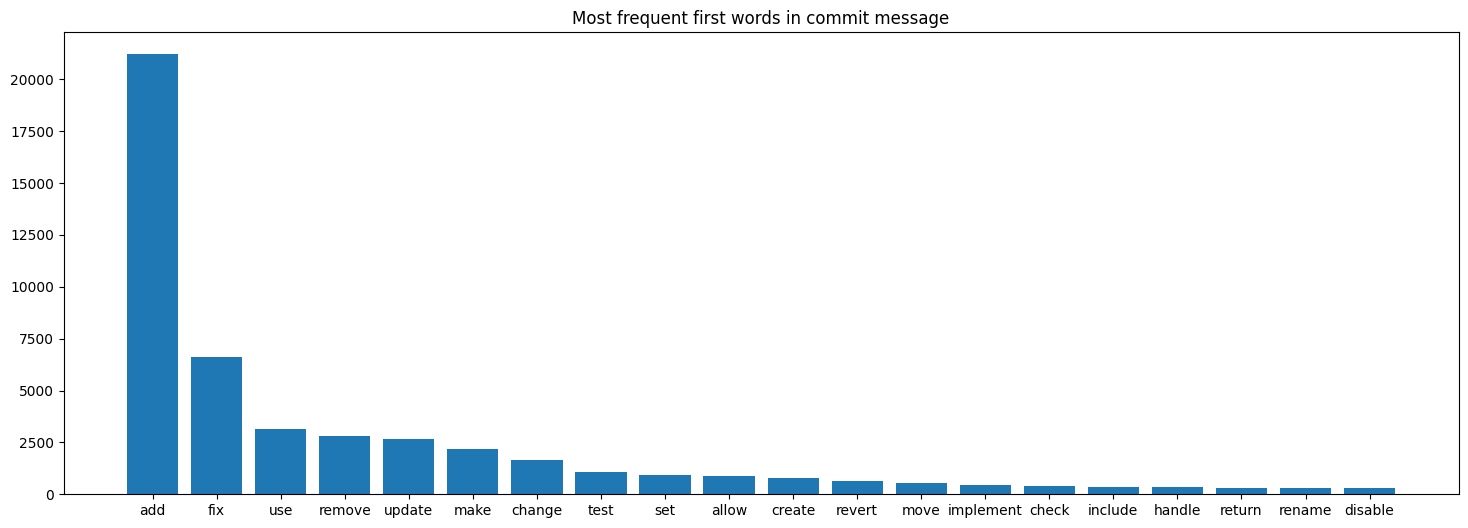

In [5]:
verbs = [x.split()[0].lower() for x in commitpack['subject']]
verbs2count = {}

plt.rcParams["figure.figsize"] = (18, 6)

for verb in verbs:
  if verb not in verbs2count:
    verbs2count[verb] = 0
  verbs2count[verb] += 1

counts = verbs2count.items()
counts = sorted(counts, key=lambda x: x[1], reverse=True)
plt.bar([counts[i][0] for i in range(20)], [counts[i][1] for i in range(20)])
plt.title("Most frequent first words in commit message")
plt.show()

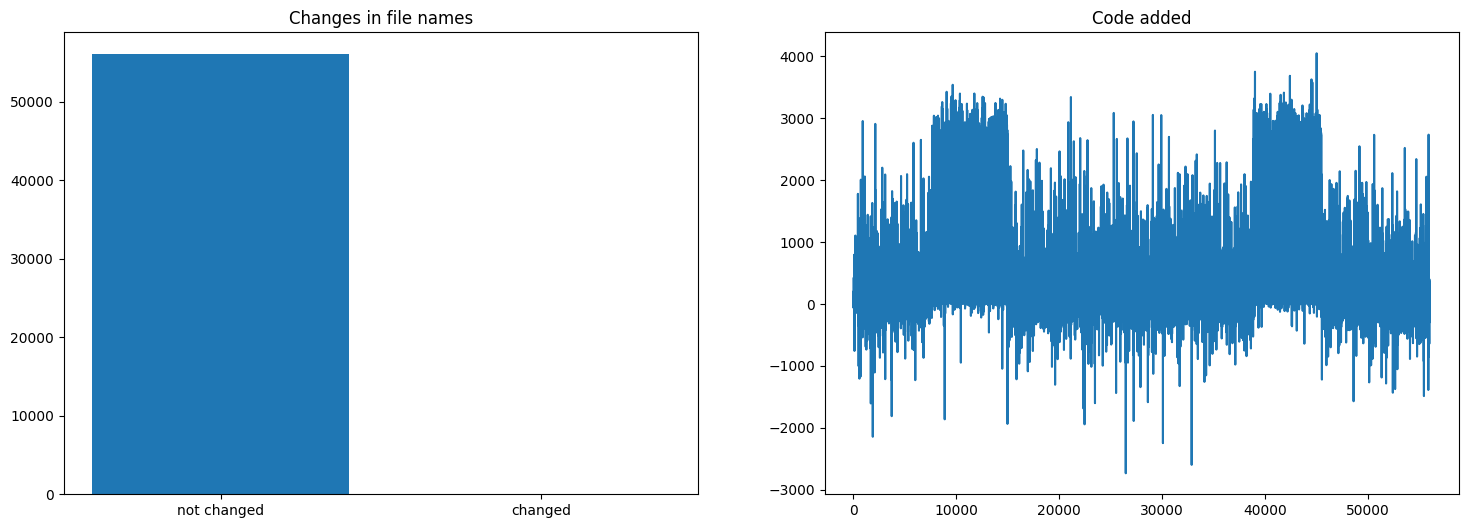

In [6]:
file_names = 0
code_changes = []

for row in commitpack:
  if row["old_file"] != row["new_file"]:
    file_names += 1
  code_changes.append(len(row["new_contents"]) - len(row["old_contents"]))

fig, axs = plt.subplots(1, 2)
axs[0].bar(["not changed", "changed"], [len(commitpack) - file_names, file_names])
axs[0].set_title("Changes in file names")

axs[1].plot(code_changes)
axs[1].set_title("Code added")

plt.show()

# **Evaluation of Refact-1.6B on HumanEvalPack-Python**

Loading dataset and metric.

In [ ]:
humaneval = load_dataset("bigcode/humanevalpack", "python")["test"]
code_eval = load("code_eval")

Creating prompt and tokenizing it. For query prompt or instruction can be used.

In [8]:
def sample_to_prompt(x):
  prompt_template = "<empty_output>SYSTEM {system}\n" \
                    "<empty_output>USER {query}.\n" \
                    "<empty_output>ASSISTANT"
  prompt = prompt_template.format(system="You are a programming assistant", query=x["prompt"])
  tokenized = tokenizer(prompt, return_tensors="pt")
  return tokenized


tokenized_humaneval = humaneval.map(sample_to_prompt)

In [9]:
references = []
candidates = []

for x in tokenized_humaneval:
  references.append(x["test"])
  outputs = model.generate(input_ids=torch.tensor(x["input_ids"], device=model.device),
                           attention_mask=torch.tensor(x["attention_mask"], device=model.device), max_length=512, temperature=0.2)
  candidates.append(tokenizer.decode(outputs[0]))

Postprocesiing predictions to extract code only.

In [10]:
def postprocess(x):
  out = x.split("<empty_output>ASSISTANT ")[-1]
  y = out.split("```")
  if len(y) > 1:
    out = y[1]
  out = out.lstrip('python').rstrip('<empty_output><|endoftext|>')
  return out


postprocessed = [[postprocess(x)] for x in candidates]

In [11]:
metric = code_eval.compute(references=references, predictions=postprocessed, k=[1])
metric

({'pass@1': 0.2865853658536585},
 defaultdict(list,
             {3: [(0,
                {'task_id': 3,
                 'passed': False,
                 'result': 'failed: ',
                 'completion_id': 0})],
              1: [(0,
                {'task_id': 1,
                 'passed': False,
                 'result': 'failed: ',
                 'completion_id': 0})],
              0: [(0,
                {'task_id': 0,
                 'passed': True,
                 'result': 'passed',
                 'completion_id': 0})],
              2: [(0,
                {'task_id': 2,
                 'passed': True,
                 'result': 'passed',
                 'completion_id': 0})],
              4: [(0,
                {'task_id': 4,
                 'passed': True,
                 'result': 'passed',
                 'completion_id': 0})],
              5: [(0,
                {'task_id': 5,
                 'passed': False,
                 'result': 'failed: ',
 

*   Results when using instruction: 22
*   Results when using prompt: 26-28

Author reported result of pass@1 = 32 which is different from these results. I assume that they might have used other prompt, since the model is sensetive to prompt.